## **Dataset description**

This project uses the [UC Berkeley-Biosense Synchronized Brainwave Dataset](https://www.kaggle.com/datasets/berkeley-biosense/synchronized-brainwave-dataset/data) which can be downloaded from Kaggle.

Each row entry in the dataset contains a data packet generated during 1 second of recording for the respective subject, whose ID is given in column 'id'.

The stimulus the subject was represented with during the corresponding time frame is given in column 'label'.

There are 30 subjects in total. 15 were presented with a video containing the exact same sequence of stimuli, and the remaining 15 saw a video showing a slightly different sequence.

[stimulus for group 1](https://https://www.youtube.com/watch?v=zkGoPdpRvaU)

[stimulus for group 2](https://https://www.youtube.com/watch?v=sxqlOoBBjvc)

The timing of all stimulus events is given in column indra_time.

For each recording window (data packet), the dataset contains both the raw single-channel EEG signal sampled at 512 Hz, and the EEG power values for 8 frequency bands. EEG signal quality is given in column signal_quality, with 0 representing optimal quality.



## **Load and clean up data**

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import math
from datetime import datetime

In [2]:
data_path = data = '/content/drive/My Drive/eeg-data.csv'
eeg = pd.read_csv(data_path)

#remove unlabeled samples
eeg = eeg.loc[~eeg["label"].isin(["unlabeled", "everyone paired"])]

#remove column Unnamed: 0 and reset index
eeg.drop(
    [
        "Unnamed: 0"
    ],
    axis=1,
    inplace=True,
)
eeg.reset_index(drop=True, inplace=True)

eeg[0:2]

,id,indra_time,browser_latency,reading_time,attention_esense,meditation_esense,eeg_power,raw_values,signal_quality,createdAt,updatedAt,label
0,7,2015-05-09 23:32:36.922,11,2015-05-09 16:32:37.095,66,53,"[56887.0, 45471.0, 20074.0, 5359.0, 22594.0, 7...","[99.0, 96.0, 91.0, 89.0, 91.0, 89.0, 87.0, 93....",0,2015-05-09 23:32:37.159,2015-05-09 23:32:37.159+00,blinkInstruction
1,5,2015-05-09 23:32:37.149,1022,2015-05-09 16:32:36.157,100,37,"[11626.0, 60301.0, 5805.0, 15729.0, 4448.0, 33...","[23.0, 40.0, 64.0, 89.0, 86.0, 33.0, -14.0, -1...",0,2015-05-09 23:32:35.193,2015-05-09 23:32:35.193+00,blinkInstruction


## **check if samples are in chronological order**

In [3]:
all_times = list(eeg['indra_time'])
sorted_times = sorted(all_times)
sorted_times == all_times

True

## **check samples with poor signal quality**

check if there are any noticeable patterns as to the subjects/stimuli types affected

In [4]:
low_quality_samples = eeg.loc[eeg['signal_quality'] > 0][['id', 'label', 'signal_quality']]
low_quality_samples.sort_values(by=['id'])

,id,label,signal_quality
223,8,relaxInstruction,26
296,8,relax,26
354,8,relax,25
310,8,relax,26
387,8,relax,25
369,8,relax,25
3366,8,colorInstruction2,26
24,10,blinkInstruction,26
192,10,relaxInstruction,51
222,10,relaxInstruction,26


### plot low quality samples by subject

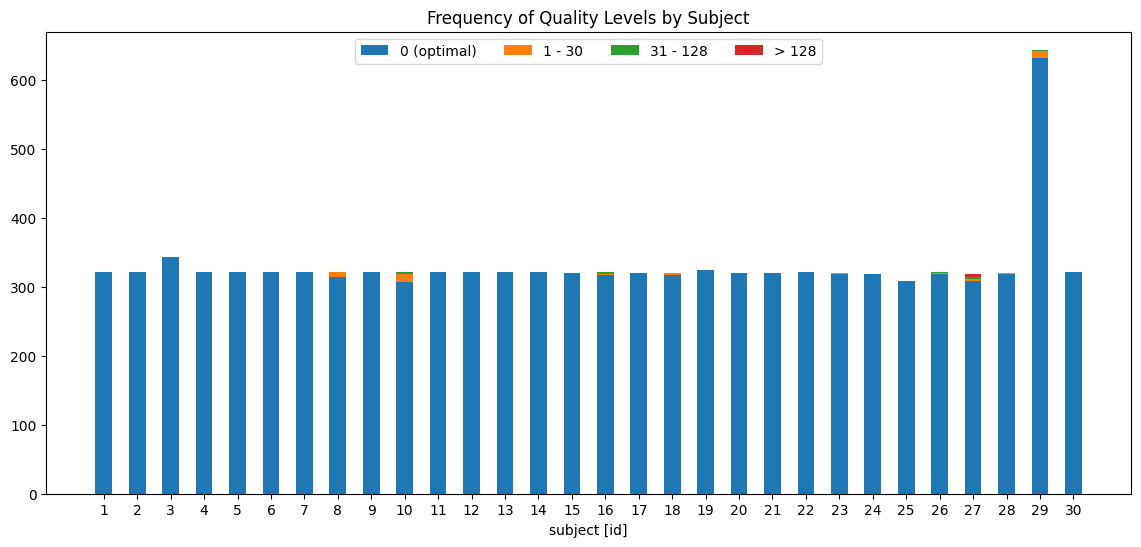

In [5]:
subjects = [str(i) for i in list(np.unique(eeg['id']))]

quality_levels = {"0 (optimal)": [], "1 - 30": [],
                  "31 - 128": [], "> 128": []
                 }

for s in subjects:
    level0 = len(eeg[(eeg['id'] == int(s)) & (eeg['signal_quality'] == 0)])
    quality_levels["0 (optimal)"].append(level0)
    level1 = len(eeg[(eeg['id'] == int(s)) & (eeg['signal_quality'] > 0) & (eeg['signal_quality'] < 31)])
    quality_levels["1 - 30"].append(level1)
    level2 = len(eeg[(eeg['id'] == int(s)) & (eeg['signal_quality'] > 30) & (eeg['signal_quality'] < 129)])
    quality_levels["31 - 128"].append(level2)
    level3 = len(eeg[(eeg['id'] == int(s)) & (eeg['signal_quality'] > 128)])
    quality_levels["> 128"].append(level3)


fix, ax = plt.subplots(figsize=(14, 6))
width = 0.5
bottom = np.zeros(len(subjects))

for quality_level, frequencies in quality_levels.items():
    ax.bar(subjects, frequencies, width, label=quality_level, bottom=bottom)
    bottom+= frequencies

ax.set_title("Frequency of Quality Levels by Subject")
ax.set_xlabel('subject [id]')
#ax.legend(loc="upper right")
ax.legend(loc='upper center', ncols=4)
plt.ylim(top = 670)
plt.show()


We can see that single subjects only have a small percentage of poor quality samples, if any. Another observation is that subject 29 has roughly twice the number of samples as all other subjects. Let's check if these are duplicates.



## **check for duplicates**

Check subject 29

In [6]:
subj29_all_samples = len(eeg[eeg['id'] == 29])
subj29_no_duplicates = eeg[eeg['id'] == 29].drop_duplicates()
subj29_no_duplicates_len = len(subj29_no_duplicates)
print('Total number of samples for subject 29: ', subj29_all_samples)
print('Number of unique samples for subject 29: ', subj29_no_duplicates_len)

Total number of samples for subject 29:  644
Number of unique samples for subject 29:  322


Check other subjects

In [7]:
data_nb_samples = len(eeg)
data_no_duplicates_len = len(eeg.drop_duplicates(subset=['id', 'label', 'raw_values']))
data_nb_samples - data_no_duplicates_len

391

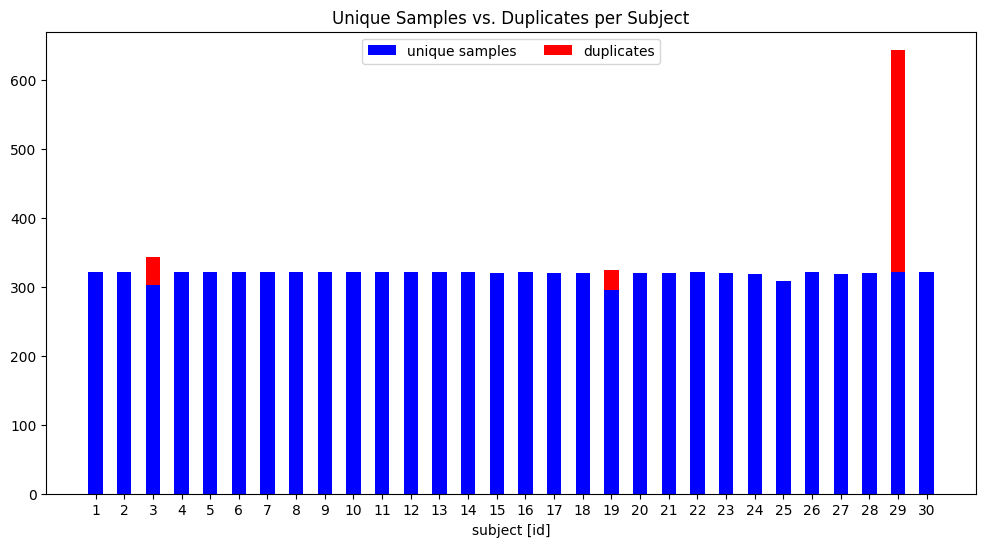

In [8]:
dupl_dict = {'unique samples': {'n': [], 'col': 'b'},
             'duplicates': {'n': [], 'col': 'r'}}
subjects = list(range(1, 31))
subjects_str = [str(x) for x in subjects]

for s in subjects:
    subj_data = eeg[eeg['id'] == s]
    len_complete = len(subj_data)
    without_dupl = subj_data.drop_duplicates(
        subset=['id', 'label', 'raw_values'],
        keep='first'
    )
    len_without_dupl = len(without_dupl)
    duplicates = len_complete - len_without_dupl
    dupl_dict['unique samples']['n'].append(len_without_dupl)
    dupl_dict['duplicates']['n'].append(duplicates)

fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(subjects))
width = 0.5

colors = ["b", "r"]

for key, entry in dupl_dict.items():
    ax.bar(subjects_str, entry['n'],
           width, bottom=bottom, label=key, color=entry['col'])
    bottom+= entry['n']

ax.set_title("Unique Samples vs. Duplicates per Subject")
ax.set_xlabel('subject [id]')
ax.legend(loc='upper center', ncols=2)
plt.ylim(top = 670)
plt.show()

We can see that the dataset contains a considerable amount of duplicates, especially for subject 29 where every single sample has a copy. When we train our model, these copies need to be removed before the train-test-split to avoid data leakage.

## merge classes and plot distribution

There are 67 unique labels in total. As we can see, different labels are used not just to indicate which type of stimuli type a subject was presented with, but also which instance and version of said stimuli type. Samples corresponding to the same type of stimulus, e.g., the blinking task, are labeled blink1, blink2, blink3 and so on.



In [9]:
#show original unique labels
all_labels = sorted(list(np.unique(eeg['label'])))
print("no. labels: ", len(all_labels))
print(all_labels)

no. labels:  67
['blink1', 'blink2', 'blink3', 'blink4', 'blink5', 'blinkInstruction', 'colorInstruction1', 'colorInstruction2', 'colorRound1-1', 'colorRound1-2', 'colorRound1-3', 'colorRound1-4', 'colorRound1-5', 'colorRound1-6', 'colorRound2-1', 'colorRound2-2', 'colorRound2-3', 'colorRound2-4', 'colorRound2-5', 'colorRound2-6', 'colorRound3-1', 'colorRound3-2', 'colorRound3-3', 'colorRound3-4', 'colorRound3-5', 'colorRound3-6', 'colorRound4-1', 'colorRound4-2', 'colorRound4-3', 'colorRound4-4', 'colorRound4-5', 'colorRound4-6', 'colorRound5-1', 'colorRound5-2', 'colorRound5-3', 'colorRound5-4', 'colorRound5-5', 'colorRound5-6', 'math1', 'math10', 'math11', 'math12', 'math2', 'math3', 'math4', 'math5', 'math6', 'math7', 'math8', 'math9', 'mathInstruction', 'music', 'musicInstruction', 'readyRound1', 'readyRound2', 'readyRound3', 'readyRound4', 'readyRound5', 'relax', 'relaxInstruction', 'thinkOfItems-ver1', 'thinkOfItems-ver2', 'thinkOfItemsInstruction-ver1', 'thinkOfItemsInstruction

Merging those different instances *i=1, ..., n* of the same type gives us a better idea of what meaningful classes are present in the dataset.

In [10]:
#merge classes by creating simplified label
#this leaves us with only 9 classes compared to original 67
eeg['simplified_label'] = eeg['label'].str.replace('\d(-\d)?|-ver|.*(?=Instruction)', '', regex=True)
nb_classes = np.unique(eeg['simplified_label']).shape[0]
print("nb. new classes: ", nb_classes)
eeg[['label', 'simplified_label']].drop_duplicates()[0:30]

nb. new classes:  9


,label,simplified_label
0,blinkInstruction,Instruction
63,blink1,blink
88,blink2,blink
110,blink3,blink
134,blink4,blink
153,blink5,blink
181,relaxInstruction,Instruction
257,relax,relax
707,mathInstruction,Instruction
786,math1,math


### plot distribution of classes

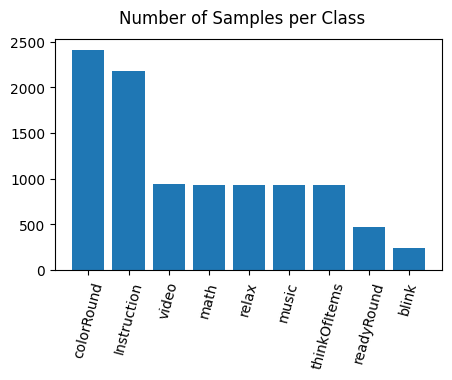

In [11]:
label_names = np.unique(eeg['simplified_label'])
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(list(eeg["simplified_label"].value_counts().keys()), list(eeg["simplified_label"].value_counts().values))
ax.set_xticks(range(len(label_names)), list(eeg["simplified_label"].value_counts().keys()), rotation=75)
fig.suptitle("Number of Samples per Class")
plt.show()

#Subject-wise distribution of classes

plot distribution of merged classes for all subjects

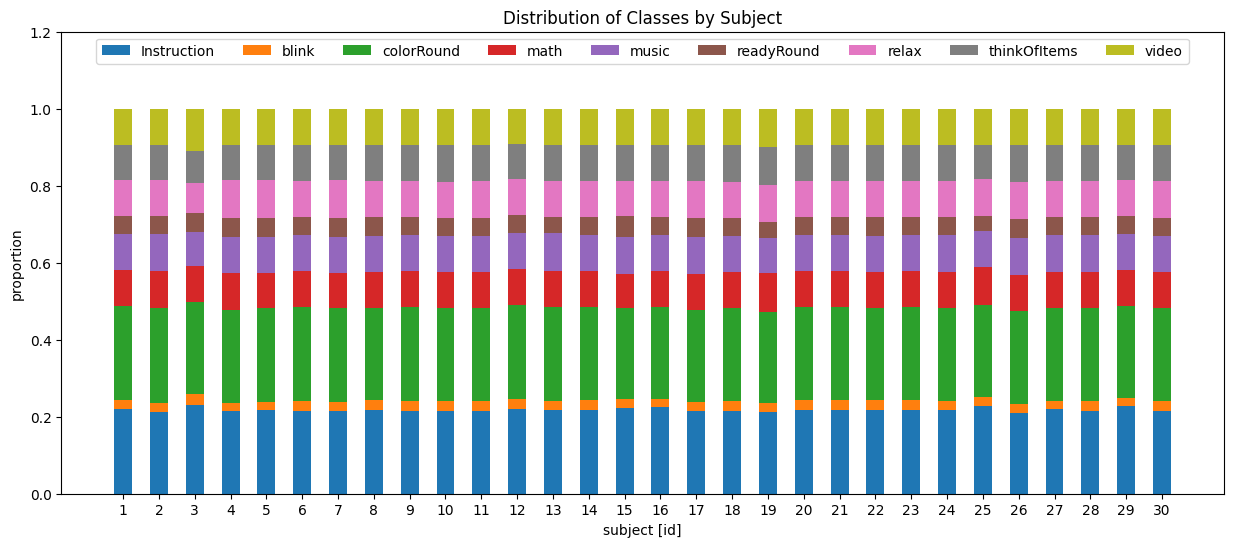

In [12]:
subjects = [str(i) for i in list(np.unique(eeg['id']))]
class_dict = {ln: [] for ln in label_names}

for s in subjects:
    for l in label_names:
        proportion_label = len(eeg[(eeg['id'] == int(s)) & (eeg['simplified_label'] == l)])/len(eeg[eeg['id'] == int(s)])
        class_dict[l].append(proportion_label)

fig, ax = plt.subplots(figsize=(15, 6))
width = 0.5
bottom = np.zeros(len(subjects))
for class_, frequencies in class_dict.items():
    #print(class_)
    ax.bar(subjects, frequencies, width, label=class_, bottom=bottom)
    bottom+= frequencies

ax.set_title("Distribution of Classes by Subject")
ax.legend(loc='upper center', ncols=len(class_dict.keys()))
ax.set_xlabel('subject [id]')
ax.set_ylabel('proportion')
plt.ylim(top = 1.2)
plt.show()

As we can see, the subjects have similar distributions of the 9 (merged) classes.